# Resources

## Youtube:

[BERT Research - Ep. 1 - Key Concepts & Sources](https://www.youtube.com/watch?v=FKlPCK1uFrc)  
[BERT Research - Ep. 2 - WordPiece Embeddings](https://www.youtube.com/watch?v=zJW57aCBCTk)  
[BERT Research - Ep. 3 - Fine Tuning - p.1](https://www.youtube.com/watch?v=x66kkDnbzi4)  
[BERT Research - Ep. 3 - Fine Tuning - p.2](https://www.youtube.com/watch?v=Hnvb9b7a_Ps)


## Jay Alammar:

[Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)  
[The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)  
[The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/)

## White Papers:

[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)  
[BERT](https://arxiv.org/pdf/1810.04805.pdf)

In [ ]:
import re
import pandas as pd

df = pd.read_csv('/content/bw_twitter_data.csv')

df = df.drop('Unnamed: 0', axis=1)

df['clean_tweets'] = [re.sub('(?P<url>https?://[^\s]+)', '', str(tweet)) for tweet in df['tweets']]
df['clean_tweets'] = [re.sub('[^0-9 a-zA-Z@#]+', '', str(tweet)) for tweet in df['clean_tweets']]
df['clean_tweets'] = [re.sub('@(.*?)[\s]', '@user ', str(tweet)) for tweet in df['clean_tweets']]

In [ ]:
df[:5]

,labels,tweets,clean_tweets
0,0,A vote against the COVID-19 Hate Crimes Act is...,A vote against the COVID19 Hate Crimes Act is ...
1,0,@thehill @SenTedCruz @tedcruz You should just ...,@user @user @user You should just not ralk you...
2,1,@Sites4Congress Police officers &amp; public o...,@user Police officers amp public officials thr...
3,1,Another Black Man Was Murder!!! Dropping tonig...,Another Black Man Was Murder Dropping tonight#...
4,0,@SonjatMorgan https://t.co/QcTEWrxMbP is a gra...,@user is a grassroots movement to say thankyo...


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
!pip install transformers wget

     |████████████████████████████████| 2.1MB 12.5MB/s 
     |████████████████████████████████| 901kB 46.3MB/s 
     |████████████████████████████████| 3.3MB 57.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=59e388dd164b7fc635ae23a511a1fa355505762fde90eb10a171e84ad85e9808
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Load Data

In [ ]:
# Load the dataset into a pandas dataframe.
# df = pd.read_csv('/content/bw_clean_tweets.csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 51,218



,labels,tweets,clean_tweets
50862,0,Week 16: Monday 04/19/21 11:50AM\nTotal tests ...,Week 16 Monday 041921 1150AMTotal tests perfor...
16059,0,Visit the below link for any query related to ...,Visit the below link for any query related to ...
40579,0,Powerful Health Opportunity and Equity (HOPE) ...,Powerful Health Opportunity and Equity HOPE mi...
46942,1,Time to organize and help the protesters in #M...,Time to organize and help the protesters in #M...
46789,1,@Bowden4Senate @RepDianaDeGette So you agree c...,@user @user So you agree civilians should be a...
11865,0,@mtgreenee @RepMaxineWaters No you should be e...,@user @user No you should be expelled from con...
8541,0,New York allowing more fans inside sports aren...,New York allowing more fans inside sports aren...
23083,1,@j321614 We are seeking the public's assistanc...,@user We are seeking the publics assistance re...
35393,0,@Yamiere1 @talkRADIO @Iromg @ClarkeMicah Or wh...,@user @user @user @user Or what does Donald Tr...
7804,1,I feel like a civil war is coming BLM vs white...,I feel like a civil war is coming BLM vs white...


In [ ]:
sentences = df.clean_tweets.values
labels = df.labels.values

# Tokenization & Formatting

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Sentences to IDs

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  A vote against the COVID19 Hate Crimes Act is a vote to retain the status quo of treating Asian Americans as secon 
Token IDs: [101, 1037, 3789, 2114, 1996, 2522, 17258, 16147, 5223, 6997, 2552, 2003, 1037, 3789, 2000, 9279, 1996, 3570, 22035, 1997, 12318, 4004, 4841, 2004, 10819, 2239, 102]


# Padding and Truncating

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


# Attention Masks

In [ ]:
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# Train/Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

## Convert to PyTorch Data Types

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# BERT for Sequence Classification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Optimizer and Learning Rate Scheduler

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

epochs = 4

total_steps = len(train_dataloader) * epochs

# learning rate scheduler (handles weight decay)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Training Loop

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,441.    Elapsed: 0:00:05.
  Batch    80  of  1,441.    Elapsed: 0:00:10.
  Batch   120  of  1,441.    Elapsed: 0:00:15.
  Batch   160  of  1,441.    Elapsed: 0:00:20.
  Batch   200  of  1,441.    Elapsed: 0:00:25.
  Batch   240  of  1,441.    Elapsed: 0:00:31.
  Batch   280  of  1,441.    Elapsed: 0:00:36.
  Batch   320  of  1,441.    Elapsed: 0:00:41.
  Batch   360  of  1,441.    Elapsed: 0:00:46.
  Batch   400  of  1,441.    Elapsed: 0:00:51.
  Batch   440  of  1,441.    Elapsed: 0:00:56.
  Batch   480  of  1,441.    Elapsed: 0:01:01.
  Batch   520  of  1,441.    Elapsed: 0:01:06.
  Batch   560  of  1,441.    Elapsed: 0:01:11.
  Batch   600  of  1,441.    Elapsed: 0:01:16.
  Batch   640  of  1,441.    Elapsed: 0:01:21.
  Batch   680  of  1,441.    Elapsed: 0:01:26.
  Batch   720  of  1,441.    Elapsed: 0:01:32.
  Batch   760  of  1,441.    Elapsed: 0:01:37.
  Batch   800  of  1,441.    Elapsed: 0:01:42.
  Batch   840  of

# Evaluate and Test

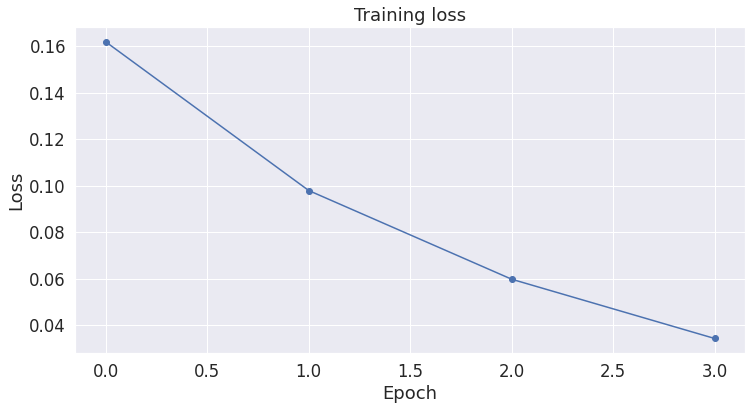

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv('/content/test.csv')

df['clean_tweets'] = [re.sub('(?P<url>https?://[^\s]+)', '', str(tweet)) for tweet in df['tweets']]
df['clean_tweets'] = [re.sub('[^0-9 a-zA-Z@#]+', '', str(tweet)) for tweet in df['clean_tweets']]
df['clean_tweets'] = [re.sub('@(.*?)[\s]', '@user ', str(tweet)) for tweet in df['clean_tweets']]

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.clean_tweets.values
labels = df.labels.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
# Start here
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,038



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,038 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.labels.sum(), len(df.labels), (df.labels.sum() / len(df.labels) * 100.0)))

Positive samples: 38 of 1038 (3.66%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.256


# Save and Load Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
!zip model_save.zip model_save/*

  adding: model_save/config.json (deflated 47%)
  adding: model_save/pytorch_model.bin (deflated 7%)
  adding: model_save/special_tokens_map.json (deflated 40%)
  adding: model_save/tokenizer_config.json (deflated 37%)
  adding: model_save/vocab.txt (deflated 53%)
